## Sparse Matrix Multiplication Comparison

In [147]:
install.packages('microbenchmark')


The downloaded binary packages are in
	/var/folders/cj/lqg5sg090wd5cm3ltjfk_fmc0000gn/T//Rtmp0BJVCx/downloaded_packages


In [1]:
library(Matrix)
library(microbenchmark)
library(ggplot2)

In [97]:
#' @title create a sparse binary matrix with certain sparsity and size(n by n) 
#' @param sparsity a double: sparsity percent entries are zeros
#' @param N nrows of output matrix
#' @param P ncol of output matrix
#' @output an N by P matrix
create_a_sparse_mat = function(sparsity, N, P){
    nonzero = round(N*P*(1-sparsity))
    testMat = sample(c(rep(1,nonzero), rep(0,N*P-nonzero)))
    testMat = matrix(testMat, N, P)
    return(testMat)    
}

In [101]:
sparsity = 0.2
N = 3000
P = 1000
#create_a_sparse_mat(sparsity,N,P)

In [99]:
# Assume: N=3000, P=1000
# record matrix multiplication: 3000*1000 times 1000*1 (something like X %*% (s$alpha[l,] * s$mu[l,]) in susieR) 
# note: 3000*1000 has sparsity 
#       1000*1 is a dense vector
N = 3000
P = 1000
alpha_l = runif(P)
matrix_vector_elapse_time = c()
matrix_vector_cross_elapse_time = c()
sparse_matrix_vector_elapse_time = c()
sparse_matrix_vector_cross_elapse_time = c()
for (ii in seq(0.3,1,by=0.01)){
    X = create_a_sparse_mat(ii, N, P)
    X_sparse = as(X, 'dgCMatrix')
    matrix_vector_elapse_time = c(matrix_vector_elapse_time,system.time(X%*%alpha_l)[3])
    matrix_vector_cross_elapse_time = c(matrix_vector_cross_elapse_time,system.time(tcrossprod(X,t(alpha_l)))[3])
    sparse_matrix_vector_elapse_time = c(sparse_matrix_vector_elapse_time,system.time(X_sparse%*%alpha_l)[3])
    sparse_matrix_vector_cross_elapse_time = c(sparse_matrix_vector_cross_elapse_time,system.time(tcrossprod(X_sparse,t(alpha_l)))[3])
}

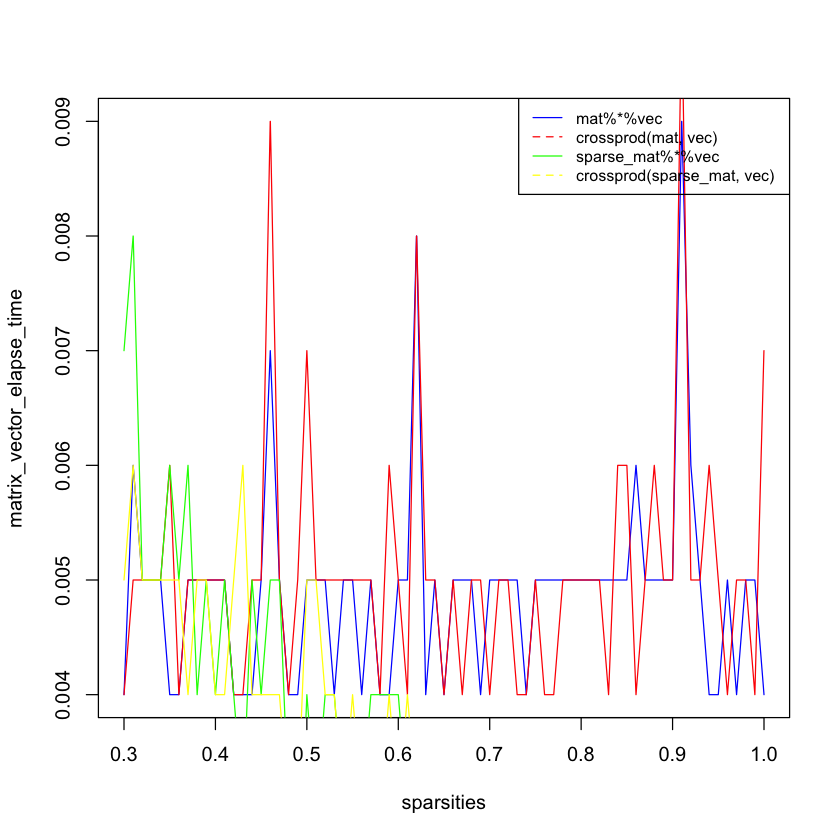

In [100]:
sparsities = seq(0.3,1,by=0.01)
plot(sparsities, matrix_vector_elapse_time, col='blue', type='l')
lines(sparsities, matrix_vector_cross_elapse_time, col='red')
lines(sparsities, sparse_matrix_vector_elapse_time, col='green')
lines(sparsities, sparse_matrix_vector_cross_elapse_time, col='yellow')
legend("topright",legend=c("mat%*%vec", "crossprod(mat, vec)", "sparse_mat%*%vec", "crossprod(sparse_mat, vec)"), 
       col=c("blue", "red", "green", "yellow"), lty=1:2, cex=0.8)

In [2]:
dat = readMM('hg19/matrix.mtx')

In [103]:
dim(dat)

[1]   32738 5898240

In [104]:
class(dat)
#The "dgTMatrix" class is the class of sparse matrices stored as (possibly redundant) triplets. 
#The internal representation is not at all unique, contrary to the one for class dgCMatrix.

[1] "dgTMatrix"
attr(,"package")
[1] "Matrix"

In [3]:
y = 1:5898240
res = dat%*%y

In [123]:
centered_sparse_mat = function(sparsity, N, P){
    set.seed(1)
    nonzero = sample(c(1,-1), size=round(N*P*(1-sparsity)), replace=TRUE, prob=c(.5,.5))
    testMat = sample(c(nonzero, rep(0,N*P-length(nonzero))))
    testMat = matrix(testMat, N, P)
    return(testMat)     
}

In [128]:
scale(centered_sparse_mat(0.7,10,10),center=FALSE, scale=FALSE)

0,0,0,0,0,-1,0,0,-1,0
0,0,0,1,0,0,1,0,0,-1
0,0,0,0,0,0,-1,0,1,0
-1,0,0,1,1,-1,0,0,0,0
0,0,1,0,-1,0,0,0,0,1
0,0,1,1,0,-1,-1,0,-1,0
0,-1,-1,0,0,0,0,1,0,-1
-1,0,0,0,0,0,-1,0,0,1
0,0,0,0,0,0,-1,0,0,0
0,0,1,0,0,0,0,1,0,1


Note: only simulate sparse matrix that is centered, but not scaled.

## Sparsity/Speed Investigations of susieR

In [126]:
devtools::install_github("stephenslab/susieR")

from URL https://api.github.com/repos/stephenslab/susieR/zipball/master
Installing susieR
'/Library/Frameworks/R.framework/Resources/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore --quiet CMD INSTALL  \
  '/private/var/folders/cj/lqg5sg090wd5cm3ltjfk_fmc0000gn/T/Rtmp0BJVCx/devtools9206235ebd55/stephenslab-susieR-2b02e9c'  \
  --library='/Library/Frameworks/R.framework/Versions/3.4/Resources/library'  \
  --install-tests 



In [127]:
library(susieR)

In [139]:
susie = function(X,Y,L=10,prior_variance=0.2,residual_variance=NULL,standardize=TRUE,intercept=TRUE,max_iter=100,tol=1e-2,estimate_residual_variance=TRUE,estimate_prior_variance = FALSE, s_init = NULL, verbose=FALSE){
  # Check input X.
  #if (!is.double(X) || !is.matrix(X))
    #stop("Input X must be a double-precision matrix")
  p = ncol(X)
  n = nrow(X)
  mean_y = mean(Y)

  if(intercept){ # center Y and X
    Y = Y-mean_y
    X = scale(X,center=FALSE, scale = FALSE)
  } else {
    attr(X,"scaled:center")=rep(0,p)
  }

  if(standardize){
    X = scale(X,center=FALSE, scale=FALSE)
  } else {
    attr(X,"scaled:scale")=rep(1,p)
  }

  # initialize susie fit
  if(!is.null(s_init)){
    if(!missing(L) || !missing(prior_variance) || !missing(residual_variance))
      stop("if provide s_init then L, sa2 and sigma2 must not be provided")
    s = s_init
  } else {

    if(is.null(residual_variance)){
      residual_variance=var(Y)
    }
    residual_variance= as.numeric(residual_variance) #avoid problems with dimension if entered as matrix


    if(length(prior_variance)==1){
      prior_variance = rep(prior_variance,L)
    }

    # Check inputs sigma and sa.
    if (length(residual_variance) != 1)
      stop("Inputs residual_variance must be scalar")
    # Check inputs sigma and sa.
    if (length(prior_variance) != L)
      stop("Inputs prior_variance must be of length 1 or L")

  #initialize susie fit
   s = list(alpha=matrix(1/p,nrow=L,ncol=p), mu=matrix(0,nrow=L,ncol=p),
           mu2 = matrix(0,nrow=L,ncol=p), Xr=rep(0,n), sigma2= residual_variance, sa2= prior_variance, KL = rep(NA,L))
    class(s) <- "susie"
  }

  #intialize elbo to NA
  elbo = rep(NA,max_iter+1)
  elbo[1] = -Inf;

  for(i in 1:max_iter){
    #s = add_null_effect(s,0)
    s = susieR:::update_each_effect(X, Y, s, estimate_prior_variance)
    if(verbose){
        print(paste0("objective:",susieR:::susie_get_objective(X,Y,s)))
    }
    if(estimate_residual_variance){
      new_sigma2 = susieR:::estimate_residual_variance(X,Y,s)
      s$sa2 = (s$sa2*s$sigma2)/new_sigma2 # this is so prior variance does not change with update
      s$sigma2 = new_sigma2
      if(verbose){
        print(paste0("objective:",susie_get_objective(X,Y,s)))
      }
    }
    #s = remove_null_effects(s)

    elbo[i+1] = susie_get_objective(X,Y,s)
    if((elbo[i+1]-elbo[i])<tol) break;
  }
  elbo = elbo[1:(i+1)] #remove trailing NAs
  s$elbo <- elbo
  s$niter <- i

  if(intercept){
    s$intercept = mean_y - sum(attr(X,"scaled:center")* (colSums(s$alpha*s$mu)/attr(X,"scaled:scale")))# estimate intercept (unshrunk)
    s$fitted = s$Xr + mean_y
  } else {
    s$intercept = 0
    s$fitted = s$Xr
  }

  s$X_column_scale_factors = attr(X,"scaled:scale")

  return(s)
}

In [162]:
N = 3000
P = 1000
sparsity = 0.7

X = centered_sparse_mat(sparsity, N, P)
X_sparse = as(X, 'dgCMatrix')
Y = sample(c(1,0), size=N, replace=TRUE, prob=c(.2,.8))

X_list = list()
X_sparse_list = list()
for (s in 1:8){
    X_list[[s]] = centered_sparse_mat(s/10+0.2, N, P)
    X_sparse_list[[s]] = as(X_list[[s]], 'dgCMatrix')
}
X_0.95 = centered_sparse_mat(0.95, N, P)
X_sparse_0.95 = as(X_0.95, 'dgCMatrix')
X_0.99 = centered_sparse_mat(0.99, N, P)
X_sparse_0.99 = as(X_0.99, 'dgCMatrix')

In [196]:
system.time(susie(X_list[[3]],Y))

   user  system elapsed 
  2.413   0.858   3.310 

In [197]:
system.time(susie(X_sparse_list[[3]],Y))

   user  system elapsed 
  2.334   0.803   3.144 

In [198]:
system.time(susie_tcrossprod(X_list[[3]],Y))

   user  system elapsed 
  2.471   0.877   3.383 

In [199]:
system.time(susie_tcrossprod(X_sparse_list[[3]],Y))

   user  system elapsed 
  2.358   0.816   3.203 

In [165]:
susie_sparse_speed = microbenchmark(
    susie_normal_0.5 = susie(X_list[[3]],Y),
    susie_sparse_0.5 = susie(X_sparse_list[[3]],Y),
    susie_normal_0.6 = susie(X_list[[4]],Y),
    susie_sparse_0.6 = susie(X_sparse_list[[4]],Y),
    susie_normal_0.7 = susie(X_list[[5]],Y),
    susie_sparse_0.7 = susie(X_sparse_list[[5]],Y),
    susie_normal_0.8 = susie(X_list[[6]],Y),
    susie_sparse_0.8 = susie(X_sparse_list[[6]],Y),
    susie_normal_0.9 = susie(X_list[[7]],Y),
    susie_sparse_0.9 = susie(X_sparse_list[[7]],Y),
    susie_normal_0.95 = susie(X_0.95,Y),
    susie_sparse_0.95 = susie(X_sparse_0.95,Y),
    susie_normal_0.99 = susie(X_0.99,Y),
    susie_sparse_0.99 = susie(X_sparse_0.99,Y),
    times=20)

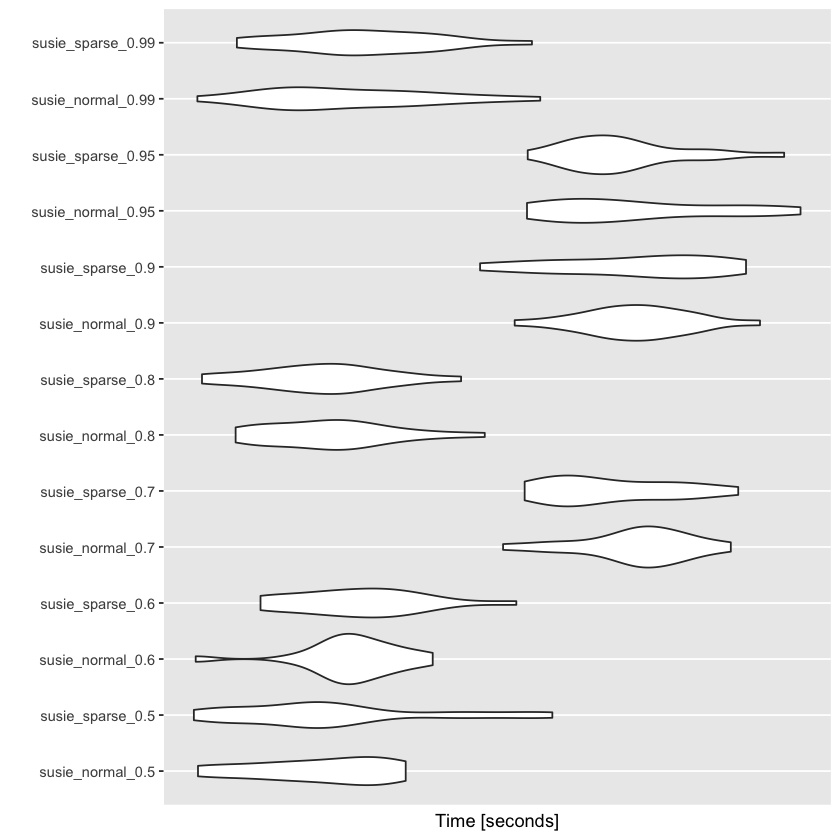

In [166]:
autoplot(susie_sparse_speed)

In [175]:
susie_tcrossprod = function(X,Y,L=10,prior_variance=0.2,residual_variance=NULL,standardize=TRUE,intercept=TRUE,max_iter=100,tol=1e-2,estimate_residual_variance=TRUE,estimate_prior_variance = FALSE, s_init = NULL, verbose=FALSE){
  # Check input X.
  #if (!is.double(X) || !is.matrix(X))
    #stop("Input X must be a double-precision matrix")
  p = ncol(X)
  n = nrow(X)
  mean_y = mean(Y)

  if(intercept){ # center Y and X
    Y = Y-mean_y
    X = scale(X,center=FALSE, scale = FALSE)
  } else {
    attr(X,"scaled:center")=rep(0,p)
  }

  if(standardize){
    X = scale(X,center=FALSE, scale=FALSE)
  } else {
    attr(X,"scaled:scale")=rep(1,p)
  }

  # initialize susie fit
  if(!is.null(s_init)){
    if(!missing(L) || !missing(prior_variance) || !missing(residual_variance))
      stop("if provide s_init then L, sa2 and sigma2 must not be provided")
    s = s_init
  } else {

    if(is.null(residual_variance)){
      residual_variance=var(Y)
    }
    residual_variance= as.numeric(residual_variance) #avoid problems with dimension if entered as matrix


    if(length(prior_variance)==1){
      prior_variance = rep(prior_variance,L)
    }

    # Check inputs sigma and sa.
    if (length(residual_variance) != 1)
      stop("Inputs residual_variance must be scalar")
    # Check inputs sigma and sa.
    if (length(prior_variance) != L)
      stop("Inputs prior_variance must be of length 1 or L")

  #initialize susie fit
   s = list(alpha=matrix(1/p,nrow=L,ncol=p), mu=matrix(0,nrow=L,ncol=p),
           mu2 = matrix(0,nrow=L,ncol=p), Xr=rep(0,n), sigma2= residual_variance, sa2= prior_variance, KL = rep(NA,L))
    class(s) <- "susie"
  }

  #intialize elbo to NA
  elbo = rep(NA,max_iter+1)
  elbo[1] = -Inf;

  for(i in 1:max_iter){
    #s = add_null_effect(s,0)
    s = update_each_effect_tcrossprod(X, Y, s, estimate_prior_variance)
    if(verbose){
        print(paste0("objective:",susieR:::susie_get_objective(X,Y,s)))
    }
    if(estimate_residual_variance){
      new_sigma2 = estimate_residual_variance_tcrossprod(X,Y,s)
      s$sa2 = (s$sa2*s$sigma2)/new_sigma2 # this is so prior variance does not change with update
      s$sigma2 = new_sigma2
      if(verbose){
        print(paste0("objective:",susieR:::susie_get_objective(X,Y,s)))
      }
    }
    #s = remove_null_effects(s)

    elbo[i+1] = susie_get_objective(X,Y,s)
    if((elbo[i+1]-elbo[i])<tol) break;
  }
  elbo = elbo[1:(i+1)] #remove trailing NAs
  s$elbo <- elbo
  s$niter <- i

  if(intercept){
    s$intercept = mean_y - sum(attr(X,"scaled:center")* (colSums(s$alpha*s$mu)/attr(X,"scaled:scale")))# estimate intercept (unshrunk)
    s$fitted = s$Xr + mean_y
  } else {
    s$intercept = 0
    s$fitted = s$Xr
  }

  s$X_column_scale_factors = attr(X,"scaled:scale")

  return(s)
}

In [171]:
update_each_effect_tcrossprod <- function (X, Y, s_init, estimate_prior_variance=FALSE) {
  # Repeat for each effect to update
  s = s_init
  L = nrow(s$alpha)

  if(L>0){
    for (l in 1:L){
    # remove lth effect from fitted values
      s$Xr = s$Xr - tcrossprod(X, t(s$alpha[l,] * s$mu[l,]))

    #compute residuals
      R = Y - s$Xr

      res = single_effect_regression_tcrossprod(R,X,s$sa2[l],s$sigma2,estimate_prior_variance)

    # Update the variational estimate of the posterior mean.
      s$mu[l,] <- res$mu
      s$alpha[l,] <- res$alpha
      s$mu2[l,] <- res$mu2
      s$sa2[l] <- res$sa2
      s$KL[l] <- -res$loglik + susieR:::SER_posterior_e_loglik(X,R,s$sigma2,res$alpha*res$mu,res$alpha*res$mu2)

      s$Xr <- s$Xr + tcrossprod(X, t(s$alpha[l,]*s$mu[l,]))
    }
  }

  return(s)
}

In [172]:
single_effect_regression_tcrossprod = function(Y,X,sa2=1,s2=1,optimize_sa2=FALSE){
  d = colSums(X^2)
  V = s2*sa2 # scale by residual variance
  betahat = (1/d) * t(X) %*% Y
  shat2 = s2/d

  if(optimize_sa2){
    if(loglik.grad_tcrossprod(0,Y,X,s2)<0){
      V=0
    } else {
      #V.o = optim(par=log(V),fn=negloglik.logscale,gr = negloglik.grad.logscale, X=X,Y=Y,s2=s2,method="BFGS")
      #if(V.o$convergence!=0){
      #  warning("optimization over prior variance failed to converge")
      #}
      V.u=uniroot(negloglik.grad.logscale,c(-10,10),extendInt = "upX",Y=Y,X=X,s2=s2)
      V = exp(V.u$root)
    }
  }

  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP

  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w is proportional to BF, but subtract max for numerical stability
  alpha = w/sum(w) # posterior prob on each SNP

  post_var = (1/V + d/s2)^(-1) # posterior variance
  post_mean = (d/s2) * post_var * betahat
  post_mean2 = post_var + post_mean^2 # second moment
  loglik = maxlbf + log(mean(w)) + sum(dnorm(Y,0,sqrt(s2),log=TRUE))

  return(list(alpha=alpha,mu=post_mean,mu2 = post_mean2,lbf=lbf,sa2=V/s2, loglik = loglik))
}


loglik.grad_tcrossprod = function(V,Y,X,s2){
  d = colSums(X^2)
  betahat = (1/d) * tcrossprod(t(X), t(Y))
  shat2 = s2/d

  lbf = dnorm(betahat,0,sqrt(V+shat2),log=TRUE) - dnorm(betahat,0,sqrt(shat2),log=TRUE)
  #log(bf) on each SNP

  maxlbf = max(lbf)
  w = exp(lbf-maxlbf) # w =BF/BFmax
  alpha = w/sum(w)
  sum(alpha*lbf.grad(V,shat2,betahat^2/shat2))
}

# define loglikelihood and gradient as function of lV:=log(V)
# to improve numerical optimization
negloglik.logscale = function(lV, Y,X,s2){-loglik(exp(lV),Y,X,s2)}
negloglik.grad.logscale = function(lV,Y,X,s2){-exp(lV)*loglik.grad_tcrossprod(exp(lV),Y,X,s2)}

#
# numDeriv::grad(negloglik.logscale,0, X =X, Y=Y,s2=s2)
# negloglik.grad.logscale(0,Y,X,s2)
#
# numDeriv::grad(loglik, 0.1, X =X, Y=Y,s2=s2)
# loglik.grad(0.1,X,Y,s2)
#
# numDeriv::grad(loglik, 1, X =X, Y=Y,s2=s2)
# loglik.grad(1,X,Y,s2)

# set.seed(1)
# n = 1000
# p = 1000
# beta = rep(0,p)
# beta[1] = 1
# X = matrix(rnorm(n*p),nrow=n,ncol=p)
# Y = X %*% beta + rnorm(n)
# s2 = 1
# optim(par=0,fn=negloglik.logscale,gr = negloglik.grad.logscale, X=X,Y=Y,s2=s2,method="BFGS")


# vector of gradients of logBF_j for each j, with respect to prior variance V
lbf.grad = function(V,shat2,T2){
  0.5* (1/(V+shat2)) * ((shat2/(V+shat2))*T2-1)
}

lbf = function(V,shat2,T2){
  0.5*log(shat2/(V+shat2)) + 0.5*T2*(V/(V+shat2))
}


In [173]:
get_ER2_tcrossprod = function(X,Y,s){
  Xr = tcrossprod((s$alpha*s$mu), X)
  Xrsum = colSums(Xr)

  d = colSums(X*X)
  postb2 = s$alpha * s$mu2 #posterior second moment

  return(sum((Y-Xrsum)^2) - sum(Xr^2) + sum(d*t(postb2)))
}

In [174]:
estimate_residual_variance_tcrossprod = function(X,Y, s){
  n = nrow(X)
  return( (1/n)* get_ER2_tcrossprod(X,Y,s) )
}

In [176]:
susie_tcrossprod(X,Y)

$alpha
             [,1]         [,2]         [,3]         [,4]         [,5]
 [1,] 0.001159865 0.0004561736 0.0006217345 0.0004326087 0.0004418422
 [2,] 0.001155441 0.0004550816 0.0006199931 0.0004316562 0.0004408622
 [3,] 0.001151951 0.0004541257 0.0006184778 0.0004308003 0.0004399860
 [4,] 0.001150133 0.0004535697 0.0006175848 0.0004302894 0.0004394666
 [5,] 0.001149797 0.0004534014 0.0006172919 0.0004301210 0.0004392985
 [6,] 0.001150470 0.0004535089 0.0006174325 0.0004301993 0.0004393818
 [7,] 0.001151743 0.0004537904 0.0006178561 0.0004304360 0.0004396254
 [8,] 0.001153352 0.0004541826 0.0006184675 0.0004307762 0.0004399735
 [9,] 0.001155143 0.0004546516 0.0006192144 0.0004311912 0.0004403980
[10,] 0.001157034 0.0004551806 0.0006200687 0.0004316668 0.0004408853
              [,6]        [,7]         [,8]         [,9]        [,10]
 [1,] 0.0009076433 0.004298952 0.0005423241 0.0004459270 0.0004558178
 [2,] 0.0009061949 0.004295360 0.0005413928 0.0004449508 0.0004547958
 [3,] 0.00090

In [177]:
susie_sparse_tcrossprod_speed = microbenchmark(
    susie_normal_0.5 = susie_tcrossprod(X_list[[3]],Y),
    susie_sparse_0.5 = susie_tcrossprod(X_sparse_list[[3]],Y),
    susie_normal_0.6 = susie_tcrossprod(X_list[[4]],Y),
    susie_sparse_0.6 = susie_tcrossprod(X_sparse_list[[4]],Y),
    susie_normal_0.7 = susie_tcrossprod(X_list[[5]],Y),
    susie_sparse_0.7 = susie_tcrossprod(X_sparse_list[[5]],Y),
    susie_normal_0.8 = susie_tcrossprod(X_list[[6]],Y),
    susie_sparse_0.8 = susie_tcrossprod(X_sparse_list[[6]],Y),
    susie_normal_0.9 = susie_tcrossprod(X_list[[7]],Y),
    susie_sparse_0.9 = susie_tcrossprod(X_sparse_list[[7]],Y),
    susie_normal_0.95 = susie_tcrossprod(X_0.95,Y),
    susie_sparse_0.95 = susie_tcrossprod(X_sparse_0.95,Y),
    susie_normal_0.99 = susie_tcrossprod(X_0.99,Y),
    susie_sparse_0.99 = susie_tcrossprod(X_sparse_0.99,Y),
    times=20)

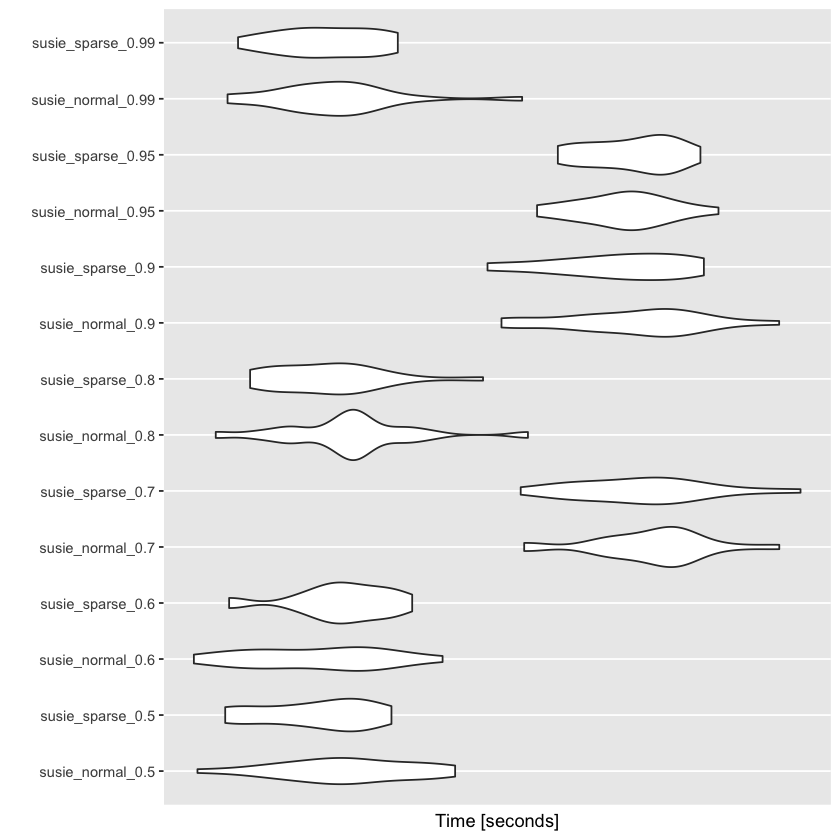

In [178]:
autoplot(susie_sparse_tcrossprod_speed)

Loading required package: gridExtra


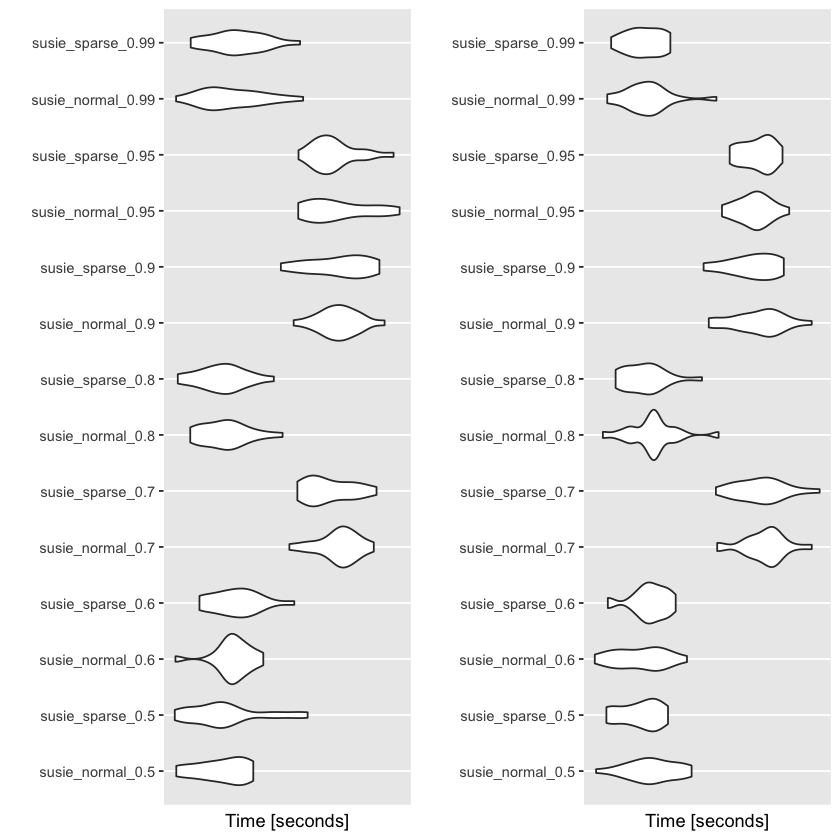

In [184]:
require(gridExtra)
plot1 = autoplot(susie_sparse_speed)
plot2 = autoplot(susie_sparse_tcrossprod_speed)
grid.arrange(plot1, plot2, ncol=2)

In [190]:
susie_simulate_speed = microbenchmark(
    susie_normal_0.5_regular = susie(X_list[[3]],Y),
    susie_normal_0.5_tcros = susie_tcrossprod(X_list[[3]],Y),
    susie_sparse_0.5_regular = susie(X_sparse_list[[3]],Y),
    susie_sparse_0.5_tcros = susie_tcrossprod(X_sparse_list[[3]],Y),
    
    susie_normal_0.6_regular = susie(X_list[[4]],Y),
    susie_normal_0.6_tcros = susie_tcrossprod(X_list[[4]],Y),
    susie_sparse_0.6_regular = susie(X_sparse_list[[4]],Y),
    susie_sparse_0.6_tcros = susie_tcrossprod(X_sparse_list[[4]],Y),
    
    susie_normal_0.7_regular = susie(X_list[[5]],Y),
    susie_normal_0.7_tcros = susie_tcrossprod(X_list[[5]],Y),
    susie_sparse_0.7_regular = susie(X_sparse_list[[5]],Y),
    susie_sparse_0.7_tcros = susie_tcrossprod(X_sparse_list[[5]],Y),
    
    susie_normal_0.8_regular = susie(X_list[[6]],Y),
    susie_normal_0.8_tcros = susie_tcrossprod(X_list[[6]],Y),
    susie_sparse_0.8_regular = susie(X_sparse_list[[6]],Y),
    susie_sparse_0.8_tcros = susie_tcrossprod(X_sparse_list[[6]],Y),
    
    susie_normal_0.9_regular = susie(X_list[[7]],Y),
    susie_normal_0.9_tcros = susie_tcrossprod(X_list[[7]],Y),
    susie_sparse_0.9_regular = susie(X_sparse_list[[7]],Y),
    susie_sparse_0.9_tcros = susie_tcrossprod(X_sparse_list[[7]],Y),
    
    susie_normal_0.95_regular = susie(X_0.95,Y),
    susie_normal_0.95_tcros = susie_tcrossprod(X_0.95,Y),
    susie_sparse_0.95_regular = susie(X_sparse_0.95,Y),
    susie_sparse_0.95_tcros = susie_tcrossprod(X_sparse_0.95,Y),
    
    susie_normal_0.99_regular = susie(X_0.99,Y),
    susie_normal_0.99_tcros = susie_tcrossprod(X_0.99,Y),
    susie_sparse_0.99_regular = susie(X_sparse_0.99,Y),
    susie_sparse_0.99_tcros = susie_tcrossprod(X_sparse_0.99,Y),
    times=10)

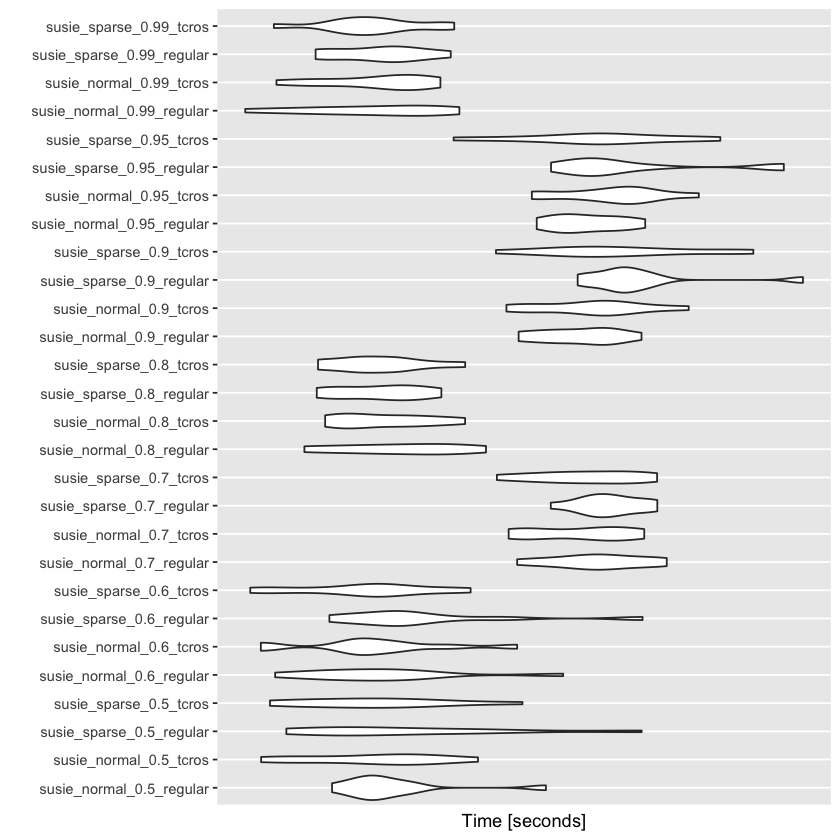

In [191]:
autoplot(susie_simulate_speed)

In [206]:
L = rnorm(1000)
simulate_speed = microbenchmark(
    normal_0.5_regular = X_list[[3]] %*% L,
    normal_0.5_tcros = tcrossprod(X_list[[3]],t(L)),
    sparse_0.5_regular = X_sparse_list[[3]] %*% L,
    sparse_0.5_tcros = tcrossprod(X_sparse_list[[3]],t(L)),
    
    normal_0.6_regular = X_list[[4]] %*% L,
    normal_0.6_tcros = tcrossprod(X_list[[4]],t(L)),
    sparse_0.6_regular = X_sparse_list[[4]] %*% L,
    sparse_0.6_tcros = tcrossprod(X_sparse_list[[4]],t(L)),
    
    normal_0.7_regular = X_list[[5]] %*% L,
    normal_0.7_tcros = tcrossprod(X_list[[5]],t(L)),
    sparse_0.7_regular = X_sparse_list[[5]] %*% L,
    sparse_0.7_tcros = tcrossprod(X_sparse_list[[5]],t(L)),
    
    normal_0.8_regular = X_list[[6]] %*% L,
    normal_0.8_tcros = tcrossprod(X_list[[6]],t(L)),
    sparse_0.8_regular = X_sparse_list[[6]] %*% L,
    sparse_0.8_tcros = tcrossprod(X_sparse_list[[6]],t(L)),
    
    normal_0.9_regular = X_list[[7]] %*% L,
    normal_0.9_tcros = tcrossprod(X_list[[7]],t(L)),
    sparse_0.9_regular = X_sparse_list[[7]] %*% L,
    sparse_0.9_tcros = tcrossprod(X_sparse_list[[7]],t(L)),
    
    normal_0.95_regular = X_0.95 %*% L,
    normal_0.95_tcros = tcrossprod(X_0.95,t(L)),
    sparse_0.95_regular = X_sparse_0.95 %*% L,
    sparse_0.95_tcros = tcrossprod(X_sparse_0.95,t(L)),
    
    normal_0.99_regular = X_0.99 %*% L,
    normal_0.99_tcros = tcrossprod(X_0.99,t(L)),
    sparse_0.99_regular = X_sparse_0.99 %*% L,
    sparse_0.99_tcros = tcrossprod(X_sparse_0.99,t(L)),
        
    times=10)

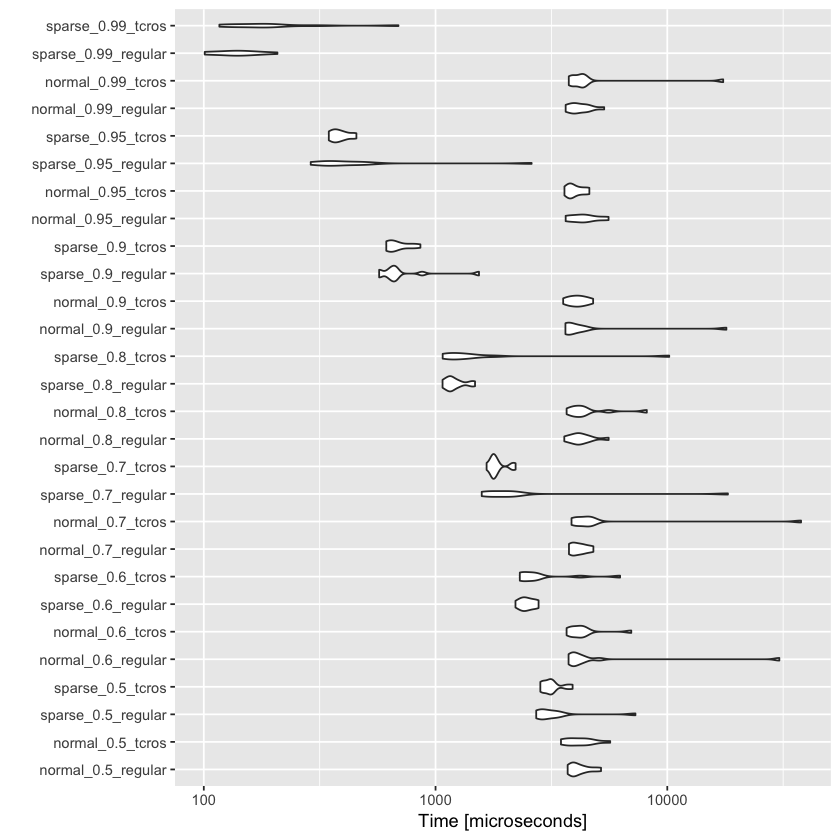

In [207]:
autoplot(simulate_speed)